### Importing required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tabulate import tabulate

### Declaring the Variables

In [3]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE=16
FOLDS=10
SCORES_PER_FOLD=[]
CLASSES=["1-1","1-2","1-4","PURE"]

In [4]:
image_dir='/content/drive/MyDrive/Project_2/BLACK_WHITE'

In [5]:
logdir='/content/drive/MyDrive/Project_2/CNN_Model_Related/Logs'

In [6]:
model_dir='/content/drive/MyDrive/Project_2/CNN_Model_Related/Model/'

In [7]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Fetching and Preprocessing the image files

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
image_data_set =tf.keras.utils.image_dataset_from_directory(
  image_dir,
  label_mode='int',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
)

Found 2240 files belonging to 4 classes.


In [10]:
train_val_set=image_data_set.take(100)
test_set=image_data_set.skip(100).take(40)
print(f'Using {len(train_val_set)} sets for Training and Validation')
print(f'Using {len(test_set)} sets for Testing')

Using 100 sets for Training and Validation
Using 40 sets for Testing


In [11]:
normalized_train_val_set=train_val_set.map(lambda x,y: (normalization_layer(x), y))
normalized_testing_set=test_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

### Building the CNN Model

In [12]:
def Build_Model():
  model=Sequential()
  
  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [13]:
# Summary of the model
model=Build_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Peforming the 10 Fold Cross Validation

In [14]:
i=0
j=10
k=90

for fold_var in range(0,FOLDS,1):
  print(f'Fold {fold_var+1}')
  print('--------------------------------------------------------------------------------------------')
  training_set1=normalized_train_val_set.take(i)
  training_set2=normalized_train_val_set.skip(i+j).take(k)
  training_set=training_set1.concatenate(training_set2)
  validation_set=normalized_train_val_set.skip(i).take(j)
  i=i+10
  j=10
  k=k-10
  
  model=Build_Model()
  Model_Run = model.fit(
    training_set,
    epochs=25,
    steps_per_epoch=len(training_set),
    callbacks=[tensorboard_callback]
  )
  print('\n')
  print(f'Evaluating the model')
  print('\n')
  cur_scores=model.evaluate(validation_set)
  cur_scores[0]*=100
  cur_scores[1]*=100
  cur_scores=[fold_var+1,cur_scores[0],cur_scores[1]]
  SCORES_PER_FOLD.append(cur_scores)

  model.save(model_dir+'model_'+str(fold_var+1)+'.h5')
  print('--------------------------------------------------------------------------------------------')
  tf.keras.backend.clear_session()


Fold 1
--------------------------------------------------------------------------------------------
Epoch 1/25
90/90 [==============================] - 166s 1s/step - loss: 0.8134 - accuracy: 0.6486
Epoch 2/25
90/90 [==============================] - 6s 56ms/step - loss: 0.4606 - accuracy: 0.8035
Epoch 3/25
90/90 [==============================] - 6s 55ms/step - loss: 0.3477 - accuracy: 0.8507
Epoch 4/25
90/90 [==============================] - 6s 55ms/step - loss: 0.4129 - accuracy: 0.8139
Epoch 5/25
90/90 [==============================] - 7s 66ms/step - loss: 0.3205 - accuracy: 0.8556
Epoch 6/25
90/90 [==============================] - 6s 54ms/step - loss: 0.4093 - accuracy: 0.8160
Epoch 7/25
90/90 [==============================] - 7s 71ms/step - loss: 0.3608 - accuracy: 0.8424
Epoch 8/25
90/90 [==============================] - 6s 55ms/step - loss: 0.3586 - accuracy: 0.8424
Epoch 9/25
90/90 [==============================] - 7s 70ms/step - loss: 0.3089 - accuracy: 0.8653
Epoch 10/

In [15]:
column_headers=['Fold Number','Validation Loss(%)','Validation Accuracy(%)']
print(tabulate(SCORES_PER_FOLD, headers=column_headers, tablefmt="grid"))

+---------------+----------------------+--------------------------+
|   Fold Number |   Validation Loss(%) |   Validation Accuracy(%) |
+===============+======================+==========================+
|             1 |             5.37363  |                   98.125 |
+---------------+----------------------+--------------------------+
|             2 |             2.06862  |                   99.375 |
+---------------+----------------------+--------------------------+
|             3 |            10.1313   |                   97.5   |
+---------------+----------------------+--------------------------+
|             4 |             7.27316  |                   96.25  |
+---------------+----------------------+--------------------------+
|             5 |             2.90648  |                   98.75  |
+---------------+----------------------+--------------------------+
|             6 |            25.3439   |                   87.5   |
+---------------+----------------------+--------

### Getting the model with highest accuracy for training

In [16]:
max_acc=SCORES_PER_FOLD[0][2]
max_acc_index=[]
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]>max_acc):
    max_acc=SCORES_PER_FOLD[i][2]
print(max_acc)
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]==max_acc):
    max_acc_index.append(i)
print(max_acc_index)
result=-1
if(len(max_acc_index)>1):
  min_loss=SCORES_PER_FOLD[max_acc_index[0]][1]
  j=0
  result=-1
  while(index<len(SCORES_PER_FOLD)):
    index=max_acc_index[j]
    if(SCORES_PER_FOLD[index][1]<min_loss):
      min_loss=SCORES_PER_FOLD[index][1]
      result=index
    j+=1
else:
  result=max_acc_index[0]

model=load_model(model_dir+'model_'+str(result+1)+'.h5')

100.0
[8]


### Training the model for fine parameter tuning

In [17]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

Cur_Model_Run = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=25,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[tensorboard_callback]
  )

Epoch 1/25
80/80 [==============================] - 12s 113ms/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 0.0279 - val_accuracy: 0.9937
Epoch 2/25
80/80 [==============================] - 10s 126ms/step - loss: 0.0079 - accuracy: 0.9984 - val_loss: 0.0124 - val_accuracy: 0.9937
Epoch 3/25
80/80 [==============================] - 10s 119ms/step - loss: 0.0089 - accuracy: 0.9992 - val_loss: 0.0088 - val_accuracy: 0.9969
Epoch 4/25
80/80 [==============================] - 9s 112ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0055 - val_accuracy: 0.9969
Epoch 5/25
80/80 [==============================] - 10s 124ms/step - loss: 7.6824e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/25
80/80 [==============================] - 10s 125ms/step - loss: 4.9897e-04 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9937
Epoch 7/25
80/80 [==============================] - 9s 114ms/step - loss: 3.8545e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accura

### Plotting the performance of the model after fine parameter tuning

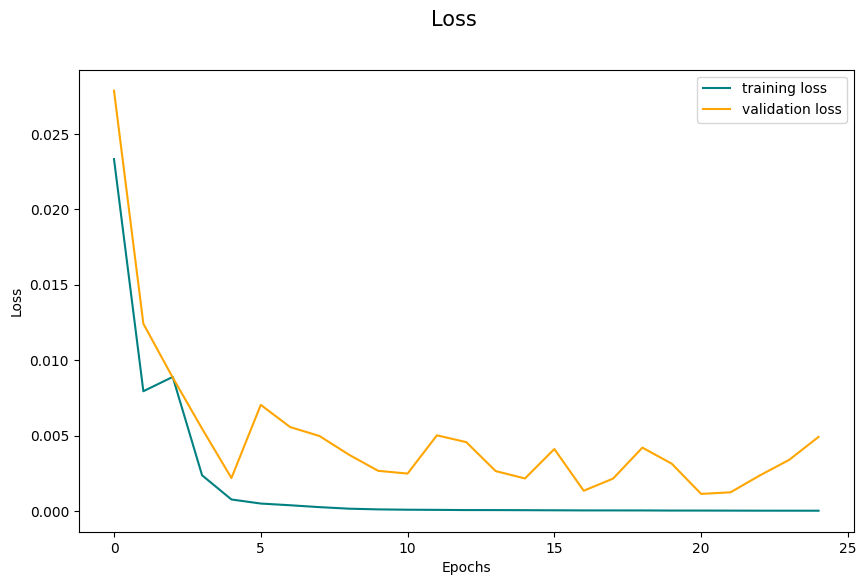

In [19]:
# Plotting the loss


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['loss'], color='teal', label='training loss')
plt.plot(Cur_Model_Run.history['val_loss'], color='orange', label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()

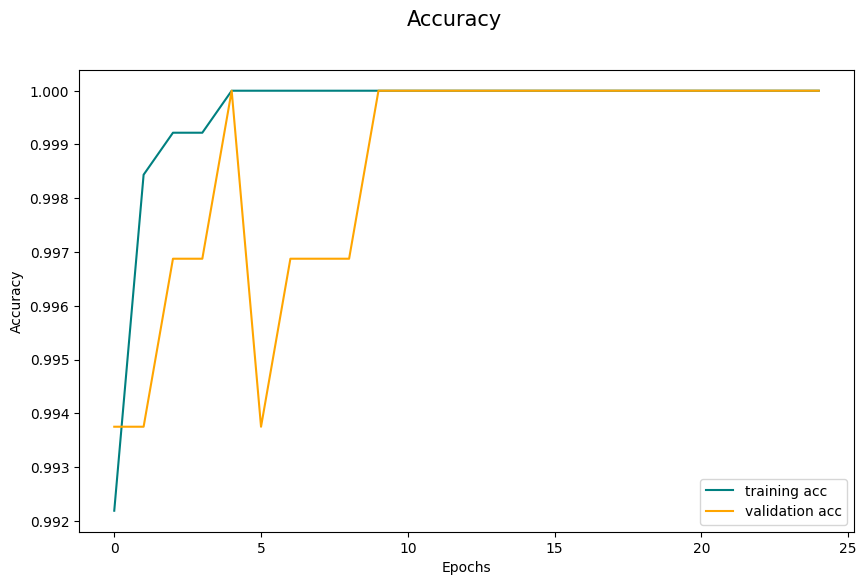

In [20]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6));
plt.plot(Cur_Model_Run.history['accuracy'], color='teal', label='training acc')
plt.plot(Cur_Model_Run.history['val_accuracy'], color='orange', label='validation acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()

###Calcualting Precision, Recall, Accuracy and F Score of the Model

In [37]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [38]:
True_label=[]
Predicted_label=[]
score=[]
for images,labels in (normalized_testing_set):              
  score.append(model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 24ms/step


In [39]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [40]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}')

Precision: 0.9959183931350708, Recall: 0.9918699264526367, Accuracy: 0.9828125238418579, F Score: 0.9938900371007287


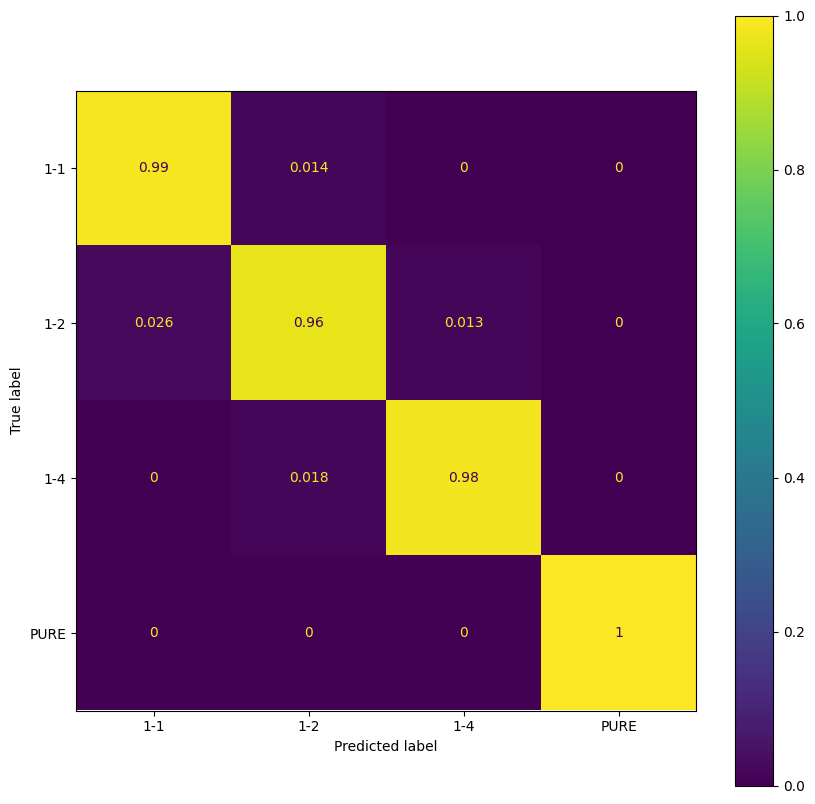

In [41]:
confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show();

### Demonstrating how to use the model

In [42]:
img=image.load_img('/content/drive/MyDrive/Project_2/BLACK_WHITE/1-4/CR_B_DU_1-4_013.jpg',target_size=(256,256))

In [43]:
x=image.img_to_array(img)

In [44]:
x=x/255

In [45]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 256, 256, 3)

In [46]:
pred=model.predict(x)

1/1 [==============================] - 0s 20ms/step


In [47]:
print(pred)

[[7.4532692e-04 2.9918236e-01 1.0000000e+00 4.4544080e-08]]


In [48]:
pred_name = CLASSES[np.argmax(pred)]
print(pred_name)

1-4
